<a href="https://colab.research.google.com/github/spdkh/NMA-Potterhead/blob/main/NN_project_Abide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

abide_data_ph = pd.read_csv("https://raw.githubusercontent.com/preprocessed-connectomes-project/abide/master/Phenotypic_V1_0b_preprocessed1.csv")

abide_data_ph

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,...,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,1,Ambi,NaN,103.0,116.0,89.0,WASI,WASI,WASI,16.0,9.0,5.0,4.0,1.0,4.0,12.0,4.0,8.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452,0.613128,45.446551,1.873339,1.054931,0.000641,0.011443,0.116828,8.0,3.980100,0.054346,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,NaN,124.0,128.0,115.0,WASI,WASI,WASI,27.0,22.0,5.0,3.0,1.0,4.0,13.0,5.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135.0,67.164179,0.041862,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,NaN,113.0,108.0,117.0,WASI,WASI,WASI,19.0,12.0,5.0,3.0,1.0,4.0,18.0,6.0,12.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29.0,14.427861,0.046745,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,119.0,117.0,118.0,WASI,WASI,WASI,23.0,19.0,3.0,4.0,1.0,4.0,12.0,4.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22.0,10.945274,0.027963,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,109.0,99.0,119.0,WASI,WASI,WASI,13.0,10.0,4.0,3.0,1.0,4.0,12.0,4.0,8.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574,0.562942,75.364679,2.213873,1.086830,0.001500,0.006919,0.070143,3.0,1.492537,0.054006,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1107,1108,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,1,NaN,100.0,95.0,105.0,84.0,WAIS_III,WAIS_III,WAIS_III,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,-9999.00,3.899774,1.697271,3.465151,3.318830,0.096813,5.434540,0.507184,91.232616,2.022145,1.278364,0.001204,0.006

In [2]:
######################################
# setting 1: define data parameters
######################################

desired_pipeline = 'cpac'
desired_strategy = 'filt_global'
desired_derivative = 'rois_cc400'
download_data_dir = '/content/drive/MyDrive/datasets/abide'
desired_age_max = 200.0
desired_age_min = -1.0
desired_site = None
desired_sex = None
desired_diagnosis = 'both'
test_to_total_ratio = 0.1 # desired ratio of test data to all data
run_mode = 'top_diff_members_of_corr_matrix' 

# can be: all_members_of_corr_matrix for use all members of corr matrix
#  for input, top_diff_members_of_corr_matrix for use only 
# The members with the most differences in the matrix between normal and ADS
# desired number of top differ members of corr matrix for 
# both end of sorted diff array between normal and autist
number_of_top_diff_members = 1000 

In [3]:

data_main_path = download_data_dir  + '/'  'Outputs' + '/' + desired_pipeline + '/' + desired_strategy + '/' + desired_derivative
corr_matrix_path = data_main_path + '.pkl'

In [4]:
# install and load needed libraries

!pip install PyPrind
import pandas as pd
import numpy as np
import os
import pyprind
import numpy.ma as ma
import pickle

In [5]:
# this part of code is from https://github.com/preprocessed-connectomes-project/abide
# for more info use this link to original repo


# download_abide_preproc.py
#
# Author: Daniel Clark, 2015
# Updated to python 3 and to support downloading by DX, Cameron Craddock, 2019

"""
This script downloads data from the Preprocessed Connetomes Project's
ABIDE Preprocessed data release and stores the files in a local
directory; users specify derivative, pipeline, strategy, and optionally
age ranges, sex, site of interest

Usage:
    python download_abide_preproc.py -d <derivative> -p <pipeline>
                                     -s <strategy> -o <out_dir>
                                     [-lt <less_than>] [-gt <greater_than>]
                                     [-x <sex>] [-t <site>]
"""


# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, less_than, greater_than, site, sex, diagnosis):
    """

    Function to collect and download images from the ABIDE preprocessed
    directory on FCP-INDI's S3 bucket

    Parameters
    ----------
    derivative : string
        derivative or measure of interest
    pipeline : string
        pipeline used to process data of interest
    strategy : string
        noise removal strategy used to process data of interest
    out_dir : string
        filepath to a local directory to save files to
    less_than : float
        upper age (years) threshold for participants of interest
    greater_than : float
        lower age (years) threshold for participants of interest
    site : string
        acquisition site of interest
    sex : string
        'M' or 'F' to indicate whether to download male or female data
    diagnosis : string
        'asd', 'tdc', or 'both' corresponding to the diagnosis of the
        participants for whom data should be downloaded

    Returns
    -------
    None
        this function does not return a value; it downloads data from
        S3 to a local directory

    :param derivative: 
    :param pipeline: 
    :param strategy: 
    :param out_dir: 
    :param less_than: 
    :param greater_than: 
    :param site: 
    :param sex:
    :param diagnosis:
    :return: 
    """

    # Import packages
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/'\
                'ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    # Format input arguments to be lower case, if not already
    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    # If output path doesn't exist, create it
    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    # Load the phenotype file from S3
    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()
    print(pheno_list[0])

    # Get header indices
    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file: {0}\nHeader should have pheno info:' \
                  ' {1}\nError: {2}'.format(s3_pheno_path, str(header), exc)
        raise Exception(err_msg)

    # Go through pheno file and build download paths
    print('Collecting images of interest...')
    s3_paths = []
    for pheno_row in pheno_list[1:]:

        # Comma separate the row
        cs_row = pheno_row.decode().split(',')

        try:
            # See if it was preprocessed
            row_file_id = cs_row[file_idx]
            # Read in participant info
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            err_msg = 'Error extracting info from phenotypic file, skipping...'
            print(err_msg)
            continue

        # If the filename isn't specified, skip
        if row_file_id == 'no_filename':
            continue
        # If mean fd is too large, skip
        if row_mean_fd >= mean_fd_thresh:
            continue

        # Test phenotypic criteria (three if's looks cleaner than one long if)
        # Test sex
        if (sex == 'M' and row_sex != '1') or (sex == 'F' and row_sex != '2'):
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        # Test site
        if site is not None and site.lower() != row_site.lower():
            continue
        # Test age range
        if greater_than < row_age < less_than:
            filename = row_file_id + '_' + derivative + extension
            s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
            print('Adding {0} to download queue...'.format(s3_path))
            s3_paths.append(s3_path)
        else:
            continue

    # And download the items
    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    # Print all done
    print('Done!')


In [6]:
# some helper function

def get_key(filename):
  f_split = filename.split('_')
  if f_split[3] == 'rois':
    key = '_'.join(f_split[0:3]) 
  else:
    key = '_'.join(f_split[0:2])
  return key


def get_label(filename):
  assert (filename in labels)
  return labels[filename]


def get_s_label(filename):
  assert (filename in s_labels)
  return s_labels[filename]


def get_a_label(filename):
  assert (filename in a_labels)
  return a_labels[filename]


def get_corr_data(filename):
  for file in os.listdir(data_main_path):
    if file.startswith(filename):
      df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
  print(df.head())       
  with np.errstate(invalid="ignore"):
    corr = np.nan_to_num(np.corrcoef(df.T))
    mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
    m = ma.masked_where(mask == 1, mask)
    return ma.masked_where(m, corr).compressed()


In [7]:
# Load or make correlation matrix

if not os.path.exists(corr_matrix_path):
  if not os.path.exists(data_main_path):
    print('Downloading preprocessed data')
    collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_age_max, desired_age_min, desired_site, desired_sex, desired_diagnosis)
  
  print('Making correlation matrix')
  flist = os.listdir(data_main_path)
  print('there are ' + str(len(flist)) + ' files')

  for f in range(len(flist)):
      flist[f] = get_key(flist[f])
      

  df_labels = pd.read_csv('https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv')

  df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2:0})
  print('there are ' + str(len(df_labels)) + ' labels')

  labels = {}
  s_labels = {}
  a_labels = {}
  for row in df_labels.iterrows():
      file_id = row[1]['FILE_ID']
      y_label = row[1]['DX_GROUP']
      age_lable = row[1]['AGE_AT_SCAN']
      sex_label = row[1]['SEX']
      if file_id == 'no_filename':
          continue
      assert(file_id not in labels)
      labels[file_id] = y_label
      s_labels[file_id] = sex_label
      a_labels[file_id] = age_lable

  #make corr matrix
  pbar=pyprind.ProgBar(len(flist))
  all_corr = {}
  for f in flist:
    lab = get_label(f)
    s_lab = get_s_label(f)
    a_lab = get_a_label(f)
    all_corr[f] = (get_corr_data(f), lab, s_lab, a_lab)
    pbar.update()

  print('Corr-computations finished')
  print('total labels & file: ' + str(len(all_corr)))
  pickle.dump(all_corr, open(corr_matrix_path , 'wb'))
  print('Saving to file finished')
else:
  all_corr = pickle.load(open(corr_matrix_path, 'rb'))

Could not find /content/drive/MyDrive/datasets/abide, creating now...
b',Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,

0% [#                             ] 100% | ETA: 00:02:51

          #1         #2         #3  ...       #398       #399       #400
0   2.967631 -19.286676   0.027782  ...  19.161556  -1.112982   6.533955
1  18.642732 -22.301707   8.773241  ...  29.397129   3.207990   4.298686
2  29.032922  -9.330153  18.881229  ...  19.387489   9.847754   1.934584
3  26.128159   8.740758  18.768332  ...  -6.603092  12.722291   4.498130
4  13.824420  14.887618   1.221778  ... -27.698425   6.358268  13.143355

[5 rows x 392 columns]
         #1         #2         #3  ...       #398       #399       #400
0  1.284509  50.949723 -41.154095  ... -10.565079  -6.958196  29.502891
1  1.667440  52.146468 -43.416177  ...  -8.547445  -9.703332  48.426888
2  4.409083  10.460677 -13.911226  ...   1.317105 -10.252396  68.977175
3  6.444084 -44.784932  27.096032  ...  10.873121  -7.430655  77.903305
4  5.783144 -69.795896  51.163871  ...  11.372452  -0.832722  69.001304

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  -3.224

0% [##                            ] 100% | ETA: 00:02:45

          #1         #2         #3  ...       #398       #399       #400
0 -30.304933 -16.451307  10.118091  ...   1.354007  30.086930  -2.533213
1 -44.479589 -10.777890  -3.291368  ...  -5.778118  35.606971 -10.486022
2 -35.352104   4.284082 -21.278532  ...  -6.964973  24.704454 -16.673646
3   4.498947  12.155542 -27.566752  ...   5.300318   3.102988 -13.260825
4  54.462732   4.196425 -15.508890  ...  27.730144 -18.322769   0.762601

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -16.504159  -8.584526  28.186981  ...  14.485754   9.579726  28.618821
1 -20.051069 -21.562637  27.699096  ...  15.372925   7.526741  33.762580
2 -10.738796 -35.238559  10.667807  ...   9.929177   8.701854  28.298335
3   8.699133 -42.869289 -17.333549  ...   3.871222  12.149683  18.040417
4  25.520311 -39.335202 -37.792259  ...  -1.327801  10.102315   8.423357

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -

0% [###                           ] 100% | ETA: 00:02:39

          #1         #2         #3  ...      #398       #399       #400
0  33.403628 -55.381667 -39.072377  ...  5.703358  19.747792 -18.270998
1  13.565928 -29.722406 -39.709681  ...  9.253214  23.391934 -10.407685
2 -15.302714  18.936935   3.387697  ...  5.790743  12.578939  -0.058883
3 -35.657048  52.563507  61.409999  ... -1.698335  -7.037194   3.633198
4 -38.492302  49.377833  82.561276  ... -4.504312 -21.290345   2.518696

[5 rows x 392 columns]
          #1         #2         #3  ...      #398       #399       #400
0   1.800544  10.699468 -12.418881  ...  7.210899  11.027352 -10.552470
1  10.802428  26.092580 -38.955419  ...  2.625965  -0.029529 -25.842463
2  19.904458  30.323026 -55.812093  ... -5.291623 -34.276857 -26.193653
3  18.988269  18.577233 -40.227742  ... -9.826670 -63.334412  -4.693455
4   9.552829  -3.042877   5.352588  ... -4.968787 -55.323619  22.773163

[5 rows x 392 columns]
          #1         #2         #3  ...      #398      #399       #400
0  10.634294  29.

0% [####                          ] 100% | ETA: 00:02:33

          #1         #2         #3  ...       #398       #399       #400
0 -38.165827 -57.543255  69.610779  ...  -5.762467  -0.281871  13.798974
1 -32.033864 -74.921521  61.248417  ...  -6.091471  34.772255  19.826005
2 -15.783932 -57.812356  19.620105  ...   2.912193  48.513166  18.262460
3  -6.225445 -16.166360 -15.157319  ...  16.974275  26.734289  16.788080
4  -9.913635  20.588578 -13.547818  ...  24.138055  -8.250280  23.821200

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -14.869938  22.770095  25.922419  ...  22.670627  -9.189471  21.286463
1  12.621164  18.009027  14.982193  ...  13.628197 -10.104333  17.013843
2  26.471877  17.291685   4.613864  ...  -7.881264   3.648935  10.789001
3   9.562580  25.290519   4.449576  ... -22.977842  19.488020   9.305257
4 -17.505779  34.257059   6.443037  ... -20.301383  21.634064  10.420003

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -

0% [#####                         ] 100% | ETA: 00:02:27

          #1         #2         #3  ...       #398       #399       #400
0  11.503617  42.386330 -12.703655  ... -33.303373  -3.171736  12.974238
1  -4.599556  46.246656 -19.170951  ... -27.005006  13.221337  -1.642263
2 -16.895201  35.131939 -12.692002  ...  -0.720633  24.031324 -25.273656
3 -15.482848  19.820756   1.954546  ...  27.553608  26.446556 -36.768289
4  -4.554529   9.394021   8.307555  ...  36.759868  25.918164 -18.886546

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -10.990503  34.323876  28.353496  ...   4.996018 -10.453731  39.436158
1 -24.791512  53.678491  41.297958  ...   9.369204 -20.232018  56.824629
2 -22.564696  49.119503  25.253569  ...  12.311640 -25.175329  41.480744
3  -3.574303  23.921274 -14.656794  ...  13.384553 -23.099436  14.622853
4  14.300658  -4.015006 -49.948072  ...   8.845599 -14.455672   6.340184

[5 rows x 392 columns]
          #1         #2         #3  ...       #398      #399       #400
0  -

0% [######                        ] 100% | ETA: 00:02:21

          #1         #2         #3  ...      #398       #399       #400
0  27.329039   5.153626  -4.826381  ... -4.305444 -15.605184   6.412725
1  30.496557 -26.657686 -17.454194  ... -1.956968 -14.073559   8.679344
2   7.798072 -43.183523 -30.728460  ... -3.862012   3.448526   8.748206
3 -23.117262 -27.190287 -39.701822  ... -7.684124  20.090424  11.653120
4 -32.961646   2.084894 -38.842664  ... -7.055990  15.934230  20.118116

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  21.100967  13.651652  27.310041  ...   5.288909  21.852447  -1.887670
1  39.520042   8.248260  31.065417  ...   8.663373  21.900763  -7.423919
2  45.717577  -0.322567  29.785984  ...  12.032780  11.595125 -11.823259
3  36.765056  -9.796262  20.003686  ...  14.600719  -4.599466 -12.900306
4  18.950729 -19.081047   0.917514  ...  15.598594 -19.267108  -9.963799

[5 rows x 392 columns]
          #1          #2         #3  ...       #398       #399       #400
0  20.79

0% [#######                       ] 100% | ETA: 00:02:15

          #1         #2         #3  ...       #398      #399      #400
0  11.801338   1.133292  -1.286382  ...  11.493245 -6.788910  7.004108
1  20.450252   4.111417   7.838994  ...   7.368650 -8.394797  8.564086
2  20.140877   8.808318   8.791698  ...  -9.410432 -6.785888  9.482313
3  12.878860   4.379946  -5.466388  ... -26.084750 -5.328993  9.775885
4   3.052296 -12.191163 -25.459203  ... -27.245771 -5.702175  6.171495

[5 rows x 392 columns]
         #1         #2        #3  ...      #398       #399       #400
0 -1.056267  23.590516  1.351308  ...  7.958230  -3.487648  -7.138543
1  1.978914  45.892557 -0.299503  ...  4.502623  -2.916107   8.278234
2  6.419187  43.363148  0.647414  ...  2.659216   1.314965  21.636752
3  4.363559  21.719361  2.940189  ...  3.438741   7.435494  23.531865
4 -6.621733   3.205689  1.275631  ...  5.285715  11.720162  14.001594

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0   4.763711 -23.319529   9.83640

0% [########                      ] 100% | ETA: 00:02:09

          #1         #2         #3  ...      #398      #399       #400
0   3.960055   3.720499 -18.931723  ...  8.681814  2.510527  10.412678
1   3.723721   9.794023 -20.040305  ...  0.660791 -1.413482  11.837272
2  -9.216897  22.746795  -6.294429  ... -9.861570 -6.343975  10.024870
3 -26.559964  31.799713   7.596883  ... -8.615941 -8.559394  13.809116
4 -30.743284  27.192567   7.168710  ...  7.480352 -5.845070  22.838994

[5 rows x 392 columns]
          #1         #2         #3  ...      #398       #399       #400
0  12.552266 -18.580678 -22.364071  ...  0.854602 -38.400063 -12.781756
1  16.258540 -23.333279   1.705017  ...  8.524250 -48.275609  -6.716910
2   6.113030 -14.105102  43.001970  ...  7.070094 -28.858151   2.221755
3  -6.942612   1.574035  65.292025  ... -1.358914   8.401554   6.232111
4  -7.351970  10.442550  43.667311  ... -6.223233  34.132586   1.477212

[5 rows x 392 columns]
          #1         #2        #3  ...      #398       #399       #400
0  -8.614376  -7.848750

0% [#########                     ] 100% | ETA: 00:02:03

          #1        #2         #3  ...       #398       #399       #400
0   9.870642 -7.618479 -19.393047  ...  -9.362089  41.143314  12.365465
1   6.682042 -8.606121 -20.691830  ...  -5.251584  42.066783  24.451061
2  -3.264511 -8.492367 -13.864512  ...   3.024772  30.550737  24.280793
3 -13.432038 -5.937739  -3.975563  ...  11.170473  12.622855  14.243247
4 -16.991458 -0.472450   1.416056  ...  14.905675  -2.320133   1.987132

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  15.090494   2.771767 -31.508781  ...   6.900796  21.428289   0.714836
1   4.027168  12.088830 -36.635161  ...  13.469545  24.700781 -18.476612
2  -6.564749  16.619020 -15.017305  ...  16.206396   9.639954 -35.953632
3  -2.652303  12.856855  16.728362  ...  13.877124  -8.993424 -39.420364
4  14.702049   4.959769  30.593718  ...   9.471677 -11.556012 -27.077399

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  -6.774

0% [##########                    ] 100% | ETA: 00:01:57

          #1         #2         #3  ...       #398       #399       #400
0  -0.183561  -0.629994  -3.844566  ...  15.395366  14.376604  -7.273297
1  -8.421150  -6.698826  -0.331209  ...   5.268239   6.702643 -16.384688
2 -14.476146 -13.816271  10.086586  ...  -7.755191 -19.240584 -12.126856
3  -2.450768 -20.673530  17.374039  ...  -4.232013 -28.381545   3.941642
4  18.916609 -24.100878  13.106350  ...  15.280100  -1.750355  20.014193

[5 rows x 392 columns]
         #1         #2         #3  ...       #398       #399       #400
0  6.359485 -47.885135  23.225602  ...  11.376315  12.240409 -32.338681
1  4.759775 -70.468169  18.943829  ...  12.382859  40.136477 -50.151877
2 -0.899341 -59.244563   6.565652  ...  12.588040  40.987228 -55.983828
3 -2.468567 -26.786857  -4.187117  ...   8.806702  21.076951 -33.507846
4  8.775207   1.136592  -9.582693  ...  -1.622764   8.161112   9.850728

[5 rows x 392 columns]
          #1         #2        #3  ...       #398       #399       #400
0  17.6570

0% [###########                   ] 100% | ETA: 00:01:51

          #1        #2         #3  ...       #398       #399      #400
0   2.177893  3.856998   9.158593  ...   0.766991  -9.056517  7.922621
1  13.972648  4.967177  15.804245  ...  -3.639174 -11.279019  6.200397
2  21.500839  1.570035  20.095747  ...  -9.796244  -5.743627  2.578774
3  19.285364 -4.214131  20.449681  ... -15.382717   4.198133 -1.760664
4   7.855745 -9.111650  17.842840  ... -17.544017  11.801072 -5.807188

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -25.762935   6.265196  15.008687  ...   8.534014 -20.155865   5.521091
1  14.719398  -7.200021  12.170798  ...   6.333683  -3.894607  -1.158867
2  42.961555 -11.686614  -0.747759  ...  -3.697204  11.565785  -5.533387
3  13.692716  -0.660964   7.492358  ...   7.499201   0.399721  -0.159467
4 -13.597698   9.008066  32.182796  ...  24.614248  -5.213460  10.892614

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -40.386108 -3

0% [############                  ] 100% | ETA: 00:01:46

          #1         #2         #3  ...       #398       #399       #400
0  -4.107504  14.869564 -24.151908  ...  -8.353616  50.959267   7.069827
1  -8.677257  19.104808 -23.244853  ...  -0.241478  69.349246  18.829596
2 -17.160504  24.825011 -13.205385  ...  24.235901  60.534852  26.547435
3 -25.296813  30.527693   0.658684  ...  50.416547  21.517492  26.122843
4 -27.238174  32.758834  10.654756  ...  57.775413 -31.394915  19.576427

[5 rows x 392 columns]
          #1        #2         #3  ...       #398      #399       #400
0  11.556552  8.205319  -5.199771  ... -14.245999 -8.440536  18.309884
1  16.076733  7.859029 -18.079034  ... -12.853845 -6.978713  12.831400
2   9.085858  6.763875 -32.892452  ...  -7.237521 -3.223504   7.494134
3  -6.375176  7.121121 -42.728975  ...  -0.201612 -0.045037   8.263964
4 -21.572727  9.860521 -40.534758  ...   4.341136 -0.061936  16.421942

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0   2.780629   

0% [#############                 ] 100% | ETA: 00:01:40

          #1         #2         #3  ...       #398       #399       #400
0  17.010757 -47.050531 -17.906503  ...  -9.989342  -6.385475  38.195301
1  27.328024 -58.206534 -26.887381  ... -14.561258 -10.794087  69.410186
2  23.722332 -37.127895 -17.040340  ... -15.868713  -6.672634  74.320998
3  10.374526  -7.002368   6.389991  ... -13.955519   3.689763  52.027186
4  -0.642907  -0.355104  23.244828  ...  -8.698496  10.896157  35.560902

[5 rows x 392 columns]
         #1         #2         #3  ...       #398      #399       #400
0  0.203335   3.148425 -11.219239  ...  -3.773580  2.293266  -8.227678
1 -4.580450   0.987098 -11.031852  ...  -9.781302  2.737469 -10.030439
2 -5.462003  -0.048738   1.745962  ... -14.020767  2.087662   0.068911
3  0.567912   4.036831  19.353566  ... -12.036774 -0.701667  18.347122
4  9.038910  12.816235  32.718745  ...  -4.436628 -5.185649  33.211577

[5 rows x 392 columns]
          #1         #2        #3  ...       #398      #399       #400
0 -14.577919  11.

0% [##############                ] 100% | ETA: 00:01:34

          #1         #2         #3  ...       #398       #399       #400
0 -11.402763  -7.815387  22.621248  ...  -7.561348 -12.403575   3.914899
1 -27.672462 -10.260791  28.098137  ... -10.243797 -18.440107 -12.233652
2 -32.472476   5.895984  15.618782  ... -15.111981 -15.481578 -26.677578
3 -17.207883  28.348144  -9.046939  ... -19.217541  -2.958737 -24.544365
4   8.474833  34.288229 -30.556851  ... -17.980216  13.748658  -5.787226

[5 rows x 392 columns]
          #1         #2         #3  ...       #398      #399      #400
0  -0.647495 -24.613162 -12.770432  ...   6.479867 -3.090494 -0.315118
1  26.610021 -37.125912 -10.506285  ...   3.224974 -7.650313  2.614491
2  50.712114 -36.021062  -8.691072  ...  -9.182886 -7.376036  5.065485
3  45.260882 -17.100035  -6.640486  ... -20.566638 -2.290969  4.457322
4   7.185227  12.583455   0.543294  ... -19.399841  3.592891  3.346102

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -12.001947  -

0% [###############               ] 100% | ETA: 00:01:28

          #1         #2        #3  ...      #398       #399       #400
0  -1.723755   2.832618  4.813594  ... -3.626327 -11.795310  16.803565
1  -0.244159   7.473557  4.017559  ... -1.832008 -12.515113  20.100958
2  -4.387994  10.451029  3.600766  ...  3.560621  -4.555385   4.194660
3 -14.130720   3.903050  3.820917  ...  9.007574   2.231011 -18.455883
4 -23.411341 -11.559386  4.694519  ...  9.426799  -0.959694 -26.844978

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -23.733070   1.991999   3.846913  ...  -9.720165 -11.324544   4.692079
1 -21.264914   8.375324   3.882456  ... -30.408503  -7.807851   0.003280
2  -4.921628   9.663902   5.813488  ... -29.801007 -10.366937  -0.815048
3  10.941287   1.314338  11.061323  ...  -9.826090 -18.119063   7.096260
4  10.682239 -11.983258  16.510001  ...   6.691760 -18.710550  19.913578

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  21.594146  -

0% [################              ] 100% | ETA: 00:01:22

          #1        #2         #3  ...       #398       #399       #400
0 -15.383999  4.594386  -4.252223  ... -14.636374 -12.706746   9.083148
1 -21.488944  4.982009  19.539659  ...   2.366178  -5.108924   9.603009
2  -3.039866  0.870882  17.040941  ...  15.970118   4.321072   7.973950
3   9.779675  0.771679 -12.171068  ...   8.535289   0.954008   9.235991
4  -4.596682  6.960516 -27.929913  ...  -4.454932  -7.898144  10.053559

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -10.077428  -2.284305  14.959921  ... -35.154577 -15.457747   4.842910
1  15.639682  -8.380277   9.867450  ... -41.397328 -27.138656  -3.935268
2  25.395804 -22.709049  -5.130923  ... -24.440819 -38.040339 -19.664466
3   6.485668 -35.646617 -25.228904  ...   8.513894 -41.476149 -33.135887
4 -29.511363 -37.491521 -40.068933  ...  36.644934 -32.473966 -34.832549

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  19.128

0% [#################             ] 100% | ETA: 00:01:16

          #1         #2         #3  ...       #398       #399       #400
0   3.895250 -25.070515 -29.552217  ... -14.624858   7.326661  -8.808725
1 -16.332080 -25.118672 -45.751250  ... -17.409994  -8.713519 -15.622381
2 -27.959214 -12.068500 -29.344463  ...  -7.742884 -24.660243 -16.853844
3 -23.295603   6.389857   8.057279  ...   6.475222 -27.784119  -8.172626
4 -10.805192  18.547716  32.041990  ...  12.602744 -19.108214   6.669779

[5 rows x 392 columns]
          #1         #2        #3  ...       #398       #399       #400
0  -0.385024  -0.137737  7.112025  ... -12.121368  18.852513   4.348366
1  27.208654  -8.495944  7.322919  ... -16.398066  40.323320   0.449304
2  44.505010 -26.406446  2.241736  ...  -9.654366  41.072538 -12.174554
3  24.896548 -39.645186 -4.911506  ...   6.517669  11.963507 -22.673438
4 -24.344857 -31.621811 -8.410311  ...  21.942342 -29.805703 -17.298534

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  34.980

0% [##################            ] 100% | ETA: 00:01:10

          #1         #2         #3  ...       #398       #399       #400
0  -4.312778  15.247322 -18.064216  ...  -0.559363 -38.571084   5.971593
1 -16.721380  52.626381  -8.177285  ...   5.183391 -19.936361  13.290952
2   0.572265  38.662288  -6.568750  ...  13.628616  26.816905  -7.043459
3  29.183674 -27.639160  -5.883467  ...  12.826044  19.745638 -32.493690
4  26.947051 -54.746728  17.277516  ...   1.117437 -13.759522 -10.940072

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399      #400
0  -2.287409   5.726454  -7.720685  ...  38.367117  14.110102 -3.314283
1  -1.305776  11.229106  12.610587  ...  39.981622   9.705274  3.722787
2  -4.701324  12.879723  28.692209  ...  14.478363  -4.199200  6.228128
3 -12.724355   6.788440  22.041517  ... -15.567176 -14.444234  0.358584
4 -17.420922  -4.720650  -5.452569  ... -24.178447 -11.332797 -8.437519

[5 rows x 392 columns]
          #1         #2         #3  ...       #398      #399       #400
0 -29.1980

0% [###################           ] 100% | ETA: 00:01:04

          #1         #2         #3  ...       #398       #399       #400
0  -3.633923  -7.447030 -18.179795  ...  -2.258086  -3.758732   9.953163
1 -13.861264   9.088900  -7.769890  ...   4.847533   4.921051  26.993699
2 -17.618813  24.677291  13.382492  ...  12.707013  11.756325  -3.937290
3  -4.264896   3.086082  10.202064  ...   2.462313  -1.255931 -49.249421
4  15.405351 -21.703209 -32.537140  ... -12.952619 -16.803059 -36.371698

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0   2.554780  -2.796891   1.504408  ...   0.872879  11.157310  -8.234432
1  18.137839  -7.803510 -16.947002  ...  -6.206253   9.839809  -6.383827
2  11.409393   0.700597 -12.270557  ...  -1.166534 -10.977228   8.900209
3 -16.831134  15.276327  10.738805  ...  17.814174  -9.039863  16.546932
4 -27.912357  27.435865   8.054980  ...  18.775993   8.619654   8.778100

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  

0% [####################          ] 100% | ETA: 00:00:58

          #1         #2         #3  ...       #398       #399       #400
0   7.486220  19.265232 -11.944269  ...  20.536779  15.662590  -4.822369
1  -0.931196  36.119851   1.385297  ...  17.259450 -18.550648   8.137319
2 -10.788716  35.811886  28.784263  ...   7.130886 -49.215565  12.785730
3 -10.975911  19.916075  40.630056  ...  -2.169314 -34.856055  -0.130650
4   4.600389   0.706788  19.456031  ...  -1.795038  23.021133 -23.439730

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399      #400
0  -1.967793  27.951711 -12.185203  ...  24.453507  -1.382165 -2.645511
1   0.865728  28.363887  -0.368654  ...  24.401002  -8.152839 -7.181787
2   0.655396   7.168395   7.334443  ...  10.133024  -4.769527 -8.706409
3  -8.127288 -18.196119  -4.350392  ...  -1.411722   6.255458 -3.463256
4 -22.378439 -25.703272 -28.222702  ...   2.533594  14.970368  8.613834

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399      #400
0  10.7338

0% [#####################         ] 100% | ETA: 00:00:53

          #1         #2         #3  ...       #398       #399       #400
0  -6.758748   2.215148  12.640805  ...   4.849760   4.544739 -18.237343
1   1.714451   5.659899  10.752942  ...  -0.066388   6.072168  12.144640
2  15.979286   2.419447  -0.393952  ...  -7.374209  -3.045519  39.356663
3  23.905715  -9.884627 -11.742754  ... -10.123171 -18.316192  30.644872
4  17.695223 -24.138975 -11.592083  ...  -3.236604 -25.305188 -10.485970

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  -1.265841  37.501858 -24.953591  ... -29.380944  -9.731496  -2.400979
1 -17.383406  55.942211 -23.106839  ... -31.771398 -11.239763  -4.950694
2 -22.727140  63.876906  -1.714202  ... -16.678988 -16.857761  -7.387942
3 -25.506319  51.858455  20.814438  ...   0.100334 -24.017946 -16.338538
4 -33.591952  21.162976  25.797140  ...   3.715921 -24.850372 -29.787185

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -

0% [######################        ] 100% | ETA: 00:00:47

          #1         #2         #3  ...       #398       #399       #400
0 -22.249387  -4.258374  14.842614  ...  12.724390  -8.833210   4.291795
1 -35.418231  -1.352272  -4.083166  ...  18.370436   6.025894  26.946480
2 -25.644229   4.426765 -25.693708  ...  14.202900  19.751416  38.234502
3   2.430459  13.439876 -32.982556  ...   7.695933  20.407858  31.192433
4  27.267061  21.465552 -23.848010  ...   8.377790   8.134263  14.340870

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  34.102631  18.679181  -6.199832  ...  17.914081   9.397260  -0.188632
1  36.190339  15.208823  -0.880758  ...  18.213991  -8.777330  -0.682129
2  18.196451  -4.163711   8.216041  ...   3.634679 -20.359262  -0.260321
3 -11.859829 -22.313141  13.329557  ... -14.877480 -13.991177   6.484174
4 -36.401349 -21.521522  11.264163  ... -22.350757   3.660944  22.669021

[5 rows x 392 columns]
          #1         #2         #3  ...      #398       #399       #400
0  -

0% [#######################       ] 100% | ETA: 00:00:41

         #1         #2         #3  ...       #398       #399       #400
0 -3.165861  -1.079884 -14.759860  ...   6.639687  10.416015   3.819962
1 -4.672829  -6.559926 -18.155936  ...   7.796089  13.477564   5.262308
2 -7.583556 -11.399395 -14.503389  ...  12.161836  11.844107   8.010436
3 -9.320631 -12.016438  -6.353359  ...  18.567148   5.989080  11.554222
4 -7.114602  -6.825510   1.044918  ...  22.772336  -1.567997  14.123181

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -16.589020  10.622209   2.291858  ... -13.203431   5.671644  -4.535212
1   0.274740  10.642940  -9.782317  ...  -7.235934  10.238513 -10.560652
2  15.458107   7.013126 -18.552815  ...  -0.138489  10.516239 -16.174026
3  13.026105   5.864907 -16.966739  ...   0.752716   6.002328 -15.490228
4  -1.000319   8.521411  -8.392622  ...  -1.296885  -2.707215  -7.845273

[5 rows x 392 columns]
          #1        #2         #3  ...       #398      #399       #400
0   2.37880

0% [########################      ] 100% | ETA: 00:00:35

         #1         #2        #3  ...       #398       #399      #400
0 -0.888700  16.154648  2.318415  ...  -2.910608  -4.738652  3.590393
1  7.926118  15.578450  8.177543  ...   0.752472   2.260608  4.547700
2  3.832602  -8.333817  7.607487  ...   1.959438   7.593692 -4.391571
3 -3.035402 -38.760604  6.783610  ... -11.569573  -8.807433 -7.467503
4  7.694993 -31.677450  9.538652  ... -19.668753 -13.902480 -2.563349

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  -7.549643  17.135332  -6.112742  ...   4.519250  18.932076  11.203553
1 -16.993722  21.599936  -7.291454  ...  -1.960856  14.933141  31.793938
2 -14.688453  12.355612   6.239589  ...  -5.322140  -4.630930  43.422153
3   2.644365  -1.396937  20.759866  ...   1.056703 -23.420093  33.505785
4  24.253055  -8.978576  17.238797  ...  12.010842 -24.788888   7.929920

[5 rows x 392 columns]
         #1         #2         #3  ...       #398       #399       #400
0 -4.647674  17.053734

0% [#########################     ] 100% | ETA: 00:00:29

          #1         #2         #3  ...      #398       #399       #400
0   3.938956   5.466864 -11.965451  ...  8.334451  -5.869304 -33.765631
1  10.128070  11.232146 -22.756280  ...  0.574032  -8.209152  -0.091585
2  11.328712  11.698360 -21.122890  ... -2.315667  -1.715531   9.388038
3   8.793606  11.072620 -15.426784  ...  1.681466  10.598886 -21.122085
4   6.556903  15.066925 -20.755200  ...  4.085966  19.147216 -60.758397

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  10.902473  15.423466 -15.061484  ...  -9.235890 -10.423189  -0.396766
1  11.052572  23.931724 -12.670132  ... -10.768800  -4.140415   2.242622
2  12.169424  21.041749  -4.945223  ...  -6.862082   3.657296   5.638410
3  14.932290   4.197093   5.962808  ...   2.783565   9.276568   8.929292
4  18.173466 -21.083508  16.228674  ...  15.378839  10.916504  11.447226

[5 rows x 392 columns]
          #1        #2         #3  ...      #398       #399      #400
0   4.881759

0% [##########################    ] 100% | ETA: 00:00:23

          #1         #2         #3  ...       #398       #399       #400
0  -4.879541  16.090171  -3.462886  ...  -2.070711 -11.636641  15.263620
1 -13.988424  17.934738 -10.112130  ...   8.029995  -2.003554  29.988566
2 -14.890595  -3.262808  -3.586658  ...  15.876599   8.406132  33.505341
3 -10.048266 -27.307371  11.059413  ...  16.799670   7.950151  19.217392
4  -6.364174 -27.556809  18.818934  ...  15.790364  -0.216136  -6.934044

[5 rows x 392 columns]
          #1        #2         #3  ...       #398       #399       #400
0  15.778449 -5.725697   7.192616  ...  -0.090872   0.129798  -9.882394
1   9.159825 -5.614891  18.902067  ...   0.601720  17.019319 -22.399759
2  10.957436 -5.843056   5.475644  ...   9.690099  27.910376 -22.469232
3  35.812296 -9.471213 -16.621120  ...  16.495948  12.909051  -7.198994
4  36.930516  1.839429 -10.928380  ...  15.766195  -8.430524   8.545269

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0 -18.125

0% [###########################   ] 100% | ETA: 00:00:17

          #1        #2         #3  ...       #398       #399       #400
0  13.629706 -5.340050  -7.669960  ...  19.326613 -16.737782   3.568591
1  22.447484 -3.881796 -18.228545  ...  23.451602  -1.103758  -0.700141
2  23.741259  0.735523 -21.228566  ...   8.185465  16.715514 -13.492766
3  14.153783  5.026986 -10.515611  ... -16.768313  21.587205 -27.661474
4  -2.587271  4.982029  11.157242  ... -33.039017   9.295851 -32.854428

[5 rows x 392 columns]
          #1         #2         #3  ...       #398      #399      #400
0  -9.288040  -4.328093  -1.668302  ...  -1.621893 -7.885466  7.129532
1 -10.765932 -12.851502   5.364886  ...  -4.598448 -6.433257  2.480513
2 -13.993185 -18.182068  12.052825  ... -11.706676 -6.021953 -2.559811
3 -18.130114 -16.039532  14.781578  ... -18.367158 -7.261576 -4.225160
4 -20.339509  -6.506814  12.510125  ... -18.544331 -8.407387 -1.196014

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0   8.353617  16.9982

0% [############################  ] 100% | ETA: 00:00:11

         #1         #2        #3  ...      #398      #399       #400
0 -3.078663  -5.146426 -4.093782  ... -0.868042 -1.099459   8.799004
1 -3.125338   0.386084 -2.668956  ...  2.167594 -1.776072  13.376449
2  0.090317   4.523881 -0.102551  ...  1.065282 -2.119692   3.120846
3  1.450294  -2.546574  0.382160  ... -3.596568 -2.812590 -13.948709
4 -0.178290 -16.540440 -3.181485  ... -3.939129 -3.738240 -22.427566

[5 rows x 392 columns]
         #1         #2         #3  ...      #398      #399       #400
0 -5.780993  -6.817870 -14.543933  ...  2.296455  0.208545 -13.430567
1 -3.908332  -6.731445 -16.945430  ...  0.928800 -3.416946  -8.494057
2 -1.200031  -2.029785 -13.718309  ... -2.282360 -4.768314   1.547415
3 -0.439699   4.952391  -6.396205  ... -5.913360 -2.484682  10.720585
4 -2.037063  10.016733   1.451979  ... -7.416255  2.219466  12.581544

[5 rows x 392 columns]
          #1        #2         #3  ...       #398      #399       #400
0  11.250583  1.444611   0.825623  ...  -2.6871

0% [############################# ] 100% | ETA: 00:00:05

          #1         #2         #3  ...       #398       #399       #400
0  12.880279   4.452076  16.178807  ...   5.930631   7.721578  11.522174
1   3.206067  -3.743426  24.704453  ...  -1.810157  17.415293   8.929931
2  -6.608472 -10.545444  27.236315  ...  -9.549707  24.585093   0.659212
3 -11.607061 -10.943264  20.959649  ... -11.929553  26.237118  -7.992915
4 -10.118392  -4.338735   7.011206  ...  -7.174462  21.417616 -10.557397

[5 rows x 392 columns]
          #1         #2         #3  ...       #398       #399       #400
0  18.286755  -8.748789  -9.275506  ... -11.665573  -3.144650  22.196057
1  37.087390 -24.707719   3.261885  ...   1.190188   1.889033  20.806352
2  43.302959 -39.838611  14.817593  ...  17.988261  10.263254  -5.699599
3  27.529279 -42.184682  10.267429  ...  29.456062   8.738337 -33.980538
4  -1.435810 -27.877487 -13.634016  ...  33.381323  -9.573713 -33.613203

[5 rows x 392 columns]
          #1        #2         #3  ...      #398       #399       #400
0 -14

0% [##############################] 100% | ETA: 00:00:00

          #1         #2         #3  ...       #398       #399       #400
0   7.053091 -13.011499 -11.182009  ...   1.067457   7.794725  -2.942372
1   8.695312 -17.200218 -19.490832  ...   6.216141   7.412511  25.297853
2   3.412970 -15.864739 -21.671369  ...  -2.745253  -5.939096  29.018794
3  -8.145703 -12.509013 -21.268526  ... -19.694454 -18.487762  -0.892316
4 -16.589080  -9.620350 -16.513710  ... -26.285155 -13.912786 -32.977078

[5 rows x 392 columns]
Corr-computations finished
total labels & file: 884



Total time elapsed: 00:02:57


Saving to file finished



## Make x_train, y_train, x_test and y_test as input for NN model
# truncate corr matrix if is setted to

In [8]:
# truncate corr matrix if is setted to

if run_mode == 'top_diff_members_of_corr_matrix' :
  number_of_corr_matrix_members = len(all_corr['Pitt_0050004'][0])
  print('number of corr matrix members in beginning: ' + str(number_of_corr_matrix_members))

  #divide whole collection to normal and autistic
  normal_participants = {}
  autistic_participants = {}
  for participant in all_corr:
    if(all_corr[participant][1] == 0):
      normal_participants[participant] = all_corr[participant]
    else:
      autistic_participants[participant] = all_corr[participant]
  
  #sum over nomal
  sum_over_nomal = np.zeros(number_of_corr_matrix_members)
  for item_n in normal_participants:
    sum_over_nomal = sum_over_nomal + normal_participants[item_n][0]

  #sum over autistic
  sum_over_autistic = np.zeros(number_of_corr_matrix_members)
  for item_a in autistic_participants:
    sum_over_autistic = sum_over_autistic + autistic_participants[item_a][0]

  print(np.shape(sum_over_nomal))

  #make diff matrix
  diff_of_normal_and_autistic_sum_over = sum_over_nomal - sum_over_autistic
  print('shape of diff_of_normal_and_autistic_sum_over: ' + str(np.shape(diff_of_normal_and_autistic_sum_over)))
  print('diff_of_normal_and_autistic_sum_over: ' + str(diff_of_normal_and_autistic_sum_over))

  #add index to diff_of_normal_and_autistic_sum_over matrix
  index_added_diff_of_normal_and_autistic_sum_over = []
  for counter in range(len(diff_of_normal_and_autistic_sum_over)):
    index_added_diff_of_normal_and_autistic_sum_over = index_added_diff_of_normal_and_autistic_sum_over + [[counter ,diff_of_normal_and_autistic_sum_over[counter]]]

  print('index_added_diff_of_normal_and_autistic_sum_over: ' + str(index_added_diff_of_normal_and_autistic_sum_over))

  #sort diff matrix
  temp_sorted_index_added_diff_of_normal_and_autistic_sum_over = np.array(index_added_diff_of_normal_and_autistic_sum_over)
  sorted_index_added_diff_of_normal_and_autistic_sum_over = temp_sorted_index_added_diff_of_normal_and_autistic_sum_over[temp_sorted_index_added_diff_of_normal_and_autistic_sum_over[:,1].argsort()]
  print('sorted_index_added_diff_of_normal_and_autistic_sum_over: ' + str(sorted_index_added_diff_of_normal_and_autistic_sum_over))

  #make a mask from first and last desired number of elements
  lower_members = number_of_top_diff_members
  upper_members = -number_of_top_diff_members

  upper_mask = sorted_index_added_diff_of_normal_and_autistic_sum_over[0:lower_members,0]
  lower_mask = sorted_index_added_diff_of_normal_and_autistic_sum_over[upper_members:,0]
  upper_lower_mask = np.concatenate((upper_mask, lower_mask))
  upper_lower_mask = upper_lower_mask.astype('int32')
  print('upper_lower_mask: ' + str(upper_lower_mask))

  # apply upper_lower_mask to data

  masked_all_corr = {}
  for ff in all_corr:
    masked_all_corr[ff] = (all_corr[ff][0][upper_lower_mask.astype(int)] , all_corr[ff][1] , all_corr[ff][2] ,all_corr[ff][3])
  
  all_corr = masked_all_corr

number of corr matrix members in beginning: 76636
(76636,)
shape of diff_of_normal_and_autistic_sum_over: (76636,)
diff_of_normal_and_autistic_sum_over: [ -6.47696838   4.62669772 -12.75152987 ...  27.05299759  17.90942374
   4.26948467]
index_added_diff_of_normal_and_autistic_sum_over: [[0, -6.47696837518194], [1, 4.626697716205051], [2, -12.751529871727694], [3, -15.290479050936671], [4, 14.00842222294618], [5, -18.18029434532613], [6, 10.809030309033801], [7, -7.88715380551788], [8, 13.10268286385633], [9, -12.957142032605201], [10, 14.61598922062586], [11, -11.8864809251981], [12, 4.6181146774109365], [13, -10.744064764837205], [14, 15.354907700578982], [15, 5.58303953097262], [16, -4.944396978510225], [17, -1.0373811735940777], [18, 2.8601224697660497], [19, -10.45670555303446], [20, -3.9334776210298656], [21, -4.049923713237909], [22, 3.4527561443487613], [23, -10.443233158941176], [24, 7.092575204154059], [25, -14.672794010442487], [26, -6.540849614421692], [27, 6.69897863433132

In [9]:


# Make x_train, y_train, x_test and *y_test* as input for NN model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = []
for x_case_counter in all_corr:
  X.append(list(all_corr[x_case_counter][0]))
X = pd.DataFrame(X)
sc = StandardScaler()
X = sc.fit_transform(X)
Y = []
for y_case_counter in all_corr:
  Y.append(all_corr[y_case_counter][1])
Y = np.asarray(Y)

print('Shape of all data as X: ' + str(np.shape(X)))
print('Shape of all data as Y: ' + str(np.shape(Y)))

x_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=0.9)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
x_valid, x_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.01)
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_to_total_ratio)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)
print('Shape of x_train: ' + str(np.shape(x_train)))
print('Shape of y_train: ' + str(np.shape(y_train)))
print('Shape of x_test: ' + str(np.shape(x_test)))
print('Shape of y_test: ' + str(np.shape(y_test)))
print('Shape of x_valid: ' + str(np.shape(x_valid)))
print('Shape of y_valid: ' + str(np.shape(y_valid)))

# input_X_dimension = np.shape(x_train)[1]
# print('input X dimension: ' + str(input_X_dimension))

Shape of all data as X: (884, 2000)
Shape of all data as Y: (884,)
Shape of x_train: (795, 2000, 1)
Shape of y_train: (795, 1)
Shape of x_test: (1, 2000, 1)
Shape of y_test: (1, 1)
Shape of x_valid: (88, 2000, 1)
Shape of y_valid: (88, 1)


In [10]:
n_timesteps, n_features, n_outputs = x_train.shape[1], 1, 1

In [11]:
import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
!pip install livelossplot
from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [ ]:
#make a model


weight_decay = 1e-4
model = Sequential()
# model.add(Dense(8, activation='relu', kernel_initializer='random_normal', input_dim = input_X_dimension))
model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='elu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='elu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='elu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='elu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# model.add(MaxPooling1D(3))
# model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, 
                activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate = 0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_98 (Conv1D)          (None, 2000, 32)          128       
                                                                 
 batch_normalization_8 (Batc  (None, 2000, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_99 (Conv1D)          (None, 2000, 32)          3104      
                                                                 
 batch_normalization_9 (Batc  (None, 2000, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 1000, 32)         0         
 g1D)                                                            
                                                     

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 1.7186 - accuracy: 0.5019 - val_loss: 210.6063 - val_accuracy: 0.5393
Epoch 2/200
1/1 [==============================] - 1s 592ms/step - loss: 134.1670 - accuracy: 0.5384 - val_loss: 103.2705 - val_accuracy: 0.5393
Epoch 3/200
1/1 [==============================] - 1s 606ms/step - loss: 72.6137 - accuracy: 0.5384 - val_loss: 34.6407 - val_accuracy: 0.6517
Epoch 4/200
1/1 [==============================] - 1s 618ms/step - loss: 18.9009 - accuracy: 0.6528 - val_loss: 135.4817 - val_accuracy: 0.4607
Epoch 5/200
1/1 [==============================] - 1s 573ms/step - loss: 58.1805 - accuracy: 0.4981 - val_loss: 153.4751 - val_accuracy: 0.4607
Epoch 6/200
1/1 [==============================] - 1s 576ms/step - loss: 59.3580 - accuracy: 0.5069 - val_loss: 120.3599 - val_accuracy: 0.5281
Epoch 7/200
1/1 [==============================] - 1s 570ms/step - loss: 39.5802 - accuracy: 0.6113 - val_loss: 82.2739 - val_accuracy: 0.62

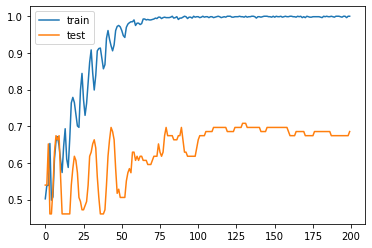

In [ ]:
#fit model

accuracy = []
F1 = []
history = model.fit(x_train, y_train, batch_size=1024, epochs= 200 , validation_data = (x_test, y_test))

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
max(history.history['val_accuracy'])

0.7078651785850525

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (2000,1)):
    inputs = Input(input_size)
    conv1 = Conv1D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv1D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv1D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    conv4 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    
    conv5 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv1D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(drop5))
    merge6 = concatenate([drop4,up6], axis = 2)
    conv6 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv1D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv6))
    merge7 = concatenate([conv3,up7], axis = 2)
    conv7 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv1D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 2)
    conv8 = Conv1D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv1D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv1D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv8))
    merge9 = concatenate([conv1,up9], axis = 2)
    conv9 = Conv1D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv1D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv1D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv1D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs, conv10)
    print(1)
    model.compile(optimizer = Adam(lr = 1e-2), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
pretrained_weights = None
model = unet(pretrained_weights, input_size = (2000,1))
model.summary()

1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d_275 (Conv1D)            (None, 2000, 16)     64          ['input_14[0][0]']               
                                                                                                  
 conv1d_276 (Conv1D)            (None, 2000, 16)     784         ['conv1d_275[0][0]']             
                                                                                                  
 max_pooling1d_98 (MaxPooling1D  (None, 1000, 16)    0           ['conv1d_276[0][0]']             
 )                                                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
num_epochs = 50
batch_size = 80
hist = model.fit(x_train, y_train,
                 epochs=num_epochs, 
                 batch_size=batch_size,
                 validation_data=(x_test, y_test))

model.save_weights('unet_weights.h5', overwrite=True)

Epoch 1/50
10/10 [==============================] - 13s 265ms/step - loss: 1.9567 - accuracy: 0.4918 - val_loss: 0.6942 - val_accuracy: 0.4607
Epoch 2/50
10/10 [==============================] - 2s 167ms/step - loss: 0.6937 - accuracy: 0.4616 - val_loss: 0.6931 - val_accuracy: 0.5393
Epoch 3/50
10/10 [==============================] - 2s 166ms/step - loss: 0.6923 - accuracy: 0.5384 - val_loss: 0.6917 - val_accuracy: 0.5393
Epoch 4/50
10/10 [==============================] - 2s 165ms/step - loss: 0.6914 - accuracy: 0.5384 - val_loss: 0.6907 - val_accuracy: 0.5393
Epoch 5/50
10/10 [==============================] - 2s 166ms/step - loss: 0.6908 - accuracy: 0.5384 - val_loss: 0.6902 - val_accuracy: 0.5393
Epoch 6/50
10/10 [==============================] - 2s 169ms/step - loss: 0.6906 - accuracy: 0.5384 - val_loss: 0.6901 - val_accuracy: 0.5393
Epoch 7/50
10/10 [==============================] - 2s 166ms/step - loss: 0.6902 - accuracy: 0.5384 - val_loss: 0.6901 - val_accuracy: 0.5393
Epoch

KeyboardInterrupt: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


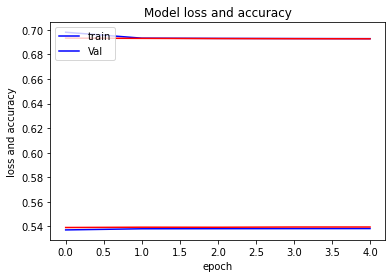

In [ ]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'],color = 'b')
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.plot(hist.history['val_loss'], color='r')


plt.title('Model loss and accuracy')
plt.ylabel('loss and accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val',], loc='upper left')
#plt.savefig(img_path % 'accuracy')


plt.show()

In [ ]:
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

# X_test, X_rem, Y_test, y_rem = train_test_split(X,Y, test_size=0.1)
X_rem, y_rem = X, Y
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(X_rem, y_rem):

    #make a model

    weight_decay = 1e-4
    model = Sequential()
    # model.add(Dense(8, activation='relu', kernel_initializer='random_normal', input_dim = input_X_dimension))
    model.add(Conv1D(filters=8,
                 kernel_size=1,
                 activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())

    model.add(Dropout(0.7))


    model.add(Flatten())
    model.add(Dense(8))
    model.add(Dropout(0.7))
    model.add(Dense(n_outputs, 
                    activation='tanh'))
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate = 0.001, decay=1e-6),
                metrics=['accuracy'])


    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    es = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    history = model.fit(X_rem[train], y_rem[train],
                        batch_size=100, epochs= 50,
                        callbacks=[es], validation_data=(X_rem[test], y_rem[test]))

    scores = model.evaluate(X_rem[test], y_rem[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
8/8 [==============================] - 2s 94ms/step - loss: 5.4641 - accuracy: 0.5434 - val_loss: 6.0752 - val_accuracy: 0.4607
Epoch 2/200
8/8 [==============================] - 1s 66ms/step - loss: 5.0386 - accuracy: 0.6075 - val_loss: 6.7270 - val_accuracy: 0.4607
Epoch 3/200
8/8 [==============================] - 1s 70ms/step - loss: 5.0659 - accuracy: 0.6226 - val_loss: 6.8878 - val_accuracy: 0.4719
Epoch 4/200
8/8 [==============================] - 1s 65ms/step - loss: 4.4731 - accuracy: 0.6579 - val_loss: 7.4946 - val_accuracy: 0.4494
Epoch 5/200
8/8 [==============================] - 1s 69ms/step - loss: 3.5977 - accuracy: 0.6642 - val_loss: 7.7361 - val_accuracy: 0.4494
Epoch 6/200
8/8 [==============================] - 1s 69ms/step - loss: 3.4776 - accuracy: 0.6440 - val_loss: 7.4198 - val_accuracy: 0.4607
Epoch 7/200
8/8 [==============================] - 1s 67ms/step

KeyboardInterrupt: ignored

In [ ]:
max(history.history['val_accuracy'])

0.625

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.3605167865753174 - Accuracy: 70.78651785850525%
------------------------------------------------------------------------
> Fold 2 - Loss: 4.655209064483643 - Accuracy: 66.29213690757751%
------------------------------------------------------------------------
> Fold 3 - Loss: 3.396658182144165 - Accuracy: 69.66292262077332%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.6860928535461426 - Accuracy: 70.78651785850525%
------------------------------------------------------------------------
> Fold 5 - Loss: 3.831156015396118 - Accuracy: 64.77272510528564%
------------------------------------------------------------------------
> Fold 6 - Loss: 3.6344916820526123 - Accuracy: 70.45454382896423%
------------------------------------------------------------------------
> 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2000, 8)           16        
                                                                 
 batch_normalization (BatchN  (None, 2000, 8)          32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2000, 8)           0         
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 4)                 64004     
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                        

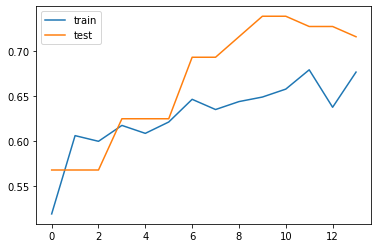

In [12]:
#make a model

import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
weight_decay = 1e-4
model = Sequential()
# model.add(Dense(8, activation='relu', kernel_initializer='random_normal', input_dim = input_X_dimension))
model.add(Conv1D(filters=8,
                 kernel_size=1,
                 activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay),
                 input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())

model.add(Dropout(0.8))


model.add(Flatten())
model.add(Dense(4))
model.add(Dropout(0.8))
model.add(Dense(n_outputs, 
                activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate = 0.001, decay=1e-6),
              metrics=['accuracy'])
model.summary()


#fit model


accuracy = []
F1 = []
csv_logger = CSVLogger("model_history_log.csv",
                    append=True)
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=epochs/10)
history = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=epochs ,
                    callbacks=[callback, csv_logger],
                    validation_data = (x_valid, y_valid),
                    verbose=1)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

0.7613636255264282

In [ ]:
!pip install h5py

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=model.predict(Xmen)

y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(Ymen, y_pred)
accuracy.append((cm[0][0] + cm[1][1])/sum(sum(cm)))
precision = cm[0][0]/(cm[0][0] + cm[1][1])
recall =  cm[0][0]/(cm[0][0] + cm[1][0])
F1.append(2 * precision * recall / (precision + recall))

print('accuracy =', np.mean(accuracy))
print('F1 =', np.mean(F1))



NameError: ignored

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 8004      
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 8,009
Trainable params: 8,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 1s 10ms/step - loss: 0.2431 - accuracy: 0.5635 - val_loss: 0.2353 - val_accuracy: 0.6250
Epoch 2/20
20/20 [==============================] - 0s 3ms/step - loss: 0.2191 - accuracy: 0.6679 - val_loss: 0.2280 - val_accuracy: 0.6250
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.2006 - accuracy: 0.6931 - val_loss: 0.2228 - val_accuracy: 0.6250
Epoch 4/20
20/20 [=========

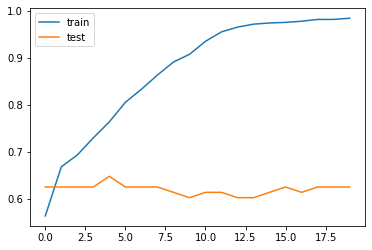

In [ ]:
#make a model

import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim = 2000))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
classifier.summary()

classifier.compile(optimizer ='adam',loss=loss_fn, metrics =['accuracy'])

#fit model

accuracy = []
F1 = []
history = classifier.fit(x_train,y_train, batch_size=40, epochs= 20 , validation_data = (x_valid, y_valid))

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Epoch 1/20
20/20 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2815 - val_accuracy: 0.6364
Epoch 2/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2808 - val_accuracy: 0.6364
Epoch 3/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2803 - val_accuracy: 0.6477
Epoch 4/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2801 - val_accuracy: 0.6477
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2793 - val_accuracy: 0.6477
Epoch 6/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2782 - val_accuracy: 0.6477
Epoch 7/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9937 - val_loss: 0.2776 - val_accuracy: 0.6477
Epoch 8/20
20/20 [==

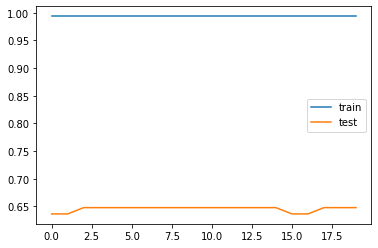